## Problem Statement
In this notebook, you will implement a Variational Autoencoder (VAE) using PyTorch.

### Tasks:
1. Implement the Encoder network to produce mean and log-variance.
2. Implement the Reparameterization Trick.
3. Implement the Decoder network to reconstruct images.
4. Implement the VAE loss function.
5. Train the VAE using the Adam optimizer.
6. Generate and visualize new images from random latent vectors.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(784,400),
            nn.ReLU()
            #raise NotImplementedError()
        )

        # write the code for Mean and Log-variance
        # YOUR CODE HERE
        self.fc_mu = nn.Linear(400,20)
        self.fc_logvar = nn.Linear(400,20)
        #raise NotImplementedError()
        
        # Decoder
        self.decoder = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(20,400),
            nn.ReLU(),
            nn.Linear(400,784),
            nn.Sigmoid()
            #raise NotImplementedError()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization Trick"""
        # write the code to Compute standard deviation from log-variance & Sample from normal distribution
        # YOUR CODE HERE
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        #raise NotImplementedError()
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Loss function
def vae_loss(reconstructed_x, x, mu, logvar):
    # Implement VAE _ LOSS Function
    # YOUR CODE HERE
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x,x,reduction='sum')
    kl_divergence = -0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())
    #raise NotImplementedError()
    return reconstruction_loss + kl_divergence
    

In [6]:
# Load dataset from 'generated_images' directory
DATASET_PATH = "/srv/shareddata/datasets/course101/minst-data-vae"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale images like MNIST
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to match MNIST format (1, 28, 28) -> (784,)
])

# Use DatasetFolder to load images without requiring subdirectories
train_dataset = datasets.DatasetFolder(root=DATASET_PATH, loader=lambda x: Image.open(x).convert("L"), extensions=('png', 'jpg', 'jpeg'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [7]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 3
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_x, mu, logvar = vae(data)
        loss = vae_loss(reconstructed_x, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}")


Epoch 1, Loss: 540.5794140625
Epoch 2, Loss: 502.70193359375
Epoch 3, Loss: 444.66857421875


[NVSHARE][INFO]: Successfully initialized nvshare GPU
[NVSHARE][INFO]: Client ID = 58c052946641e577


In [8]:
# Generate new images
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # Sample random latent vectors
    samples = vae.decode(z).cpu().numpy()


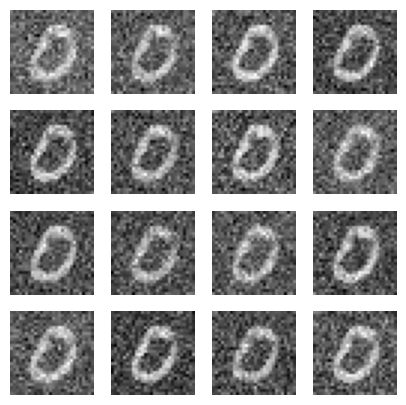

In [9]:
# Plot generated images
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()
